In [1]:
import pandas as pd
import numpy as np
import edhec_risk_ph as erk
%load_ext autoreload
%autoreload 2
ind_return = erk.get_ind_returns()
tmi_return = erk.get_total_market_index_returns()

In [2]:
tmi_return.head()

,TotalMarketReturn
1926-07,0.031375
1926-08,0.028957
1926-09,0.005566
1926-10,-0.028504
1926-11,0.028039


In [3]:
risky_r = ind_return["2000":][["Steel", "Fin", "Beer"]]
#safe asset return
safe_r = pd.DataFrame().reindex_like(risky_r)

In [4]:
safe_r.shape, risky_r.shape

((228, 3), (228, 3))

In [5]:
safe_r[:] = 0.03 / 12
start = 1000
floor = 0.8


#steps
1. Cushion = (portfolio value - floor value)
2. Allocate to safe and risky asset = m * risk budget
3. recompute the asset value based on the returns

In [6]:
#these do the same thing but the second is faster
def compound(r):
    """Compute the compounded return given a series of returns"""
    return (1 + r).prod() - 1

def compound2(r):
    """Compute the compounded return given a series of returns"""
    return np.expm1(np.log1p(r).sum())

In [15]:
%timeit compound2(risky_r)

61.7 μs ± 233 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [43]:
%timeit compound(risky_r)
dates = risky_r.index
n_steps = len(dates)
account_value = start
floor_value = start * floor
m = 3  # multiplier
account_history = pd.DataFrame().reindex_like(risky_r)
cushion_history = pd.DataFrame().reindex_like(risky_r)
risky_w_history = pd.DataFrame().reindex_like(risky_r)


for step in range(n_steps):
    cushion = (account_value - floor_value) / account_value
    risky_w = m * cushion
    risky_w = np.minimum(risky_w, 1)  # cap risky weight at 100%
    risky_w = np.maximum(risky_w, 0)  # flooor risky weight at 0%
    safe_w = 1 - risky_w
    risky_alloc = account_value * risky_w
    safe_alloc = account_value * safe_w

    #recompute the account value based on the returns
    account_value = risky_alloc * (1 + risky_r.iloc[step]) + safe_alloc * (1 + safe_r.iloc[step])
    
    #store history
    account_history.iloc[step] = account_value
    cushion_history.iloc[step] = cushion
    risky_w_history.iloc[step] = risky_w

64.1 μs ± 235 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [44]:
account_history.head()

,Steel,Fin,Beer
2000-01,984.380000,974.480000,987.320000
2000-02,1023.292876,931.167544,922.971256
2000-03,1047.555176,998.187296,924.835988
2000-04,1042.079009,973.927479,939.993701
2000-05,1007.137753,1001.460033,991.145489


<Axes: title={'center': 'Wealth Path of Risky Asset Strategy'}>

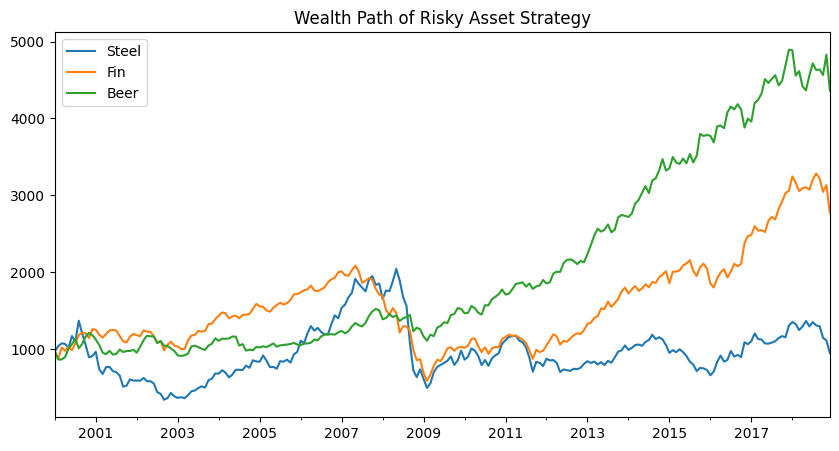

In [46]:
risky_wealth = start * (1 + risky_r).cumprod()
risky_wealth.plot(figsize=(10, 5), title="Wealth Path of Risky Asset Strategy")

In [ ]:
industry = "Beer"
ax = account_history[industry].plot(figsize=(10, 5), title="CPPI Strategy Wealth Path", label="CPPI")
risky_wealth[industry].plot(ax=ax, style="g--", label="Risky Asset")
ax.axhline(y=floor * start, color="r", linestyle="--", label="Floor")
ax.legend()
ax.set_xlabel("Date")
ax.set_ylabel("Wealth ($)")

<Axes: title={'center': 'Risky Weight History'}>

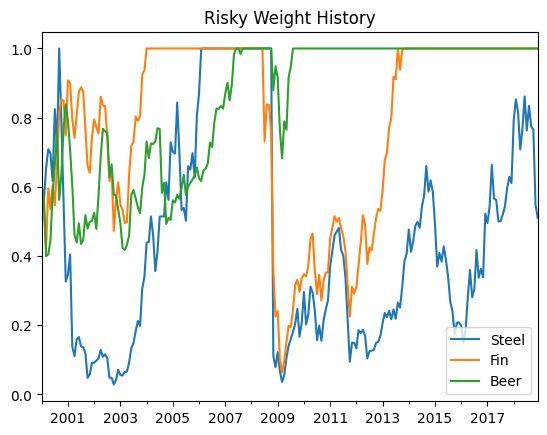

In [51]:
risky_w_history.plot(title="Risky Weight History")

Text(0, 0.5, 'Wealth ($)')

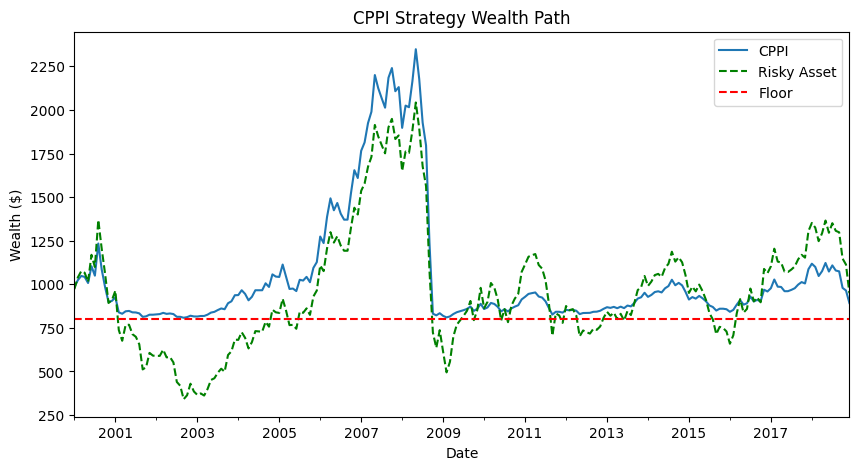

In [55]:
industry = "Steel"
ax = account_history[industry].plot(figsize=(10, 5), title="CPPI Strategy Wealth Path", label="CPPI")
risky_wealth[industry].plot(ax=ax, style="g--", label="Risky Asset")
ax.axhline(y=floor * start, color="r", linestyle="--", label="Floor")
ax.legend()
ax.set_xlabel("Date")
ax.set_ylabel("Wealth ($)")

In [ ]:
def run_cppi(risky_r, safe_r=None, m=3, start=1000, floor=0.8,riskfree_rate=0.03):
    """
    Run a backtest of the CPPI strategy, given a set of returns for the risky asset
    Returns a dictionary containing: Asset Value History, Risk Budget History, and Risky Weight History
    """
    # Set up the safe asset
    if safe_r is None:
        safe_r = pd.DataFrame().reindex_like(risky_r)
        safe_r[:] = riskfree_rate / 12
    
    # Set up some parameters
    dates = risky_r.index
    n_steps = len(dates)
    account_value = start
    floor_value = start * floor

    if isinstance(risky_r, pd.Series):
        risky_r = pd.DataFrame(risky_r, columns=["R"])
    
    # Set up DataFrames for saving intermediate values
    account_history = pd.DataFrame().reindex_like(risky_r)
    cushion_history = pd.DataFrame().reindex_like(risky_r)
    risky_w_history = pd.DataFrame().reindex_like(risky_r)
    
    for step in range(n_steps):
        cushion = (account_value - floor_value) / account_value
        risky_w = m * cushion
        risky_w = np.minimum(risky_w, 1)  # cap risky weight at 100%
        risky_w = np.maximum(risky_w, 0)  # floor risky weight at 0%
        safe_w = 1 - risky_w
        risky_alloc = account_value * risky_w
        safe_alloc = account_value * safe_w
        
        # recompute the account value based on the returns
        account_value = risky_alloc * (1 + risky_r.iloc[step]) + safe_alloc * (1 + safe_r.iloc[step])
        
        # store history
        account_history.iloc[step] = account_value
        cushion_history.iloc[step] = cushion
        risky_w_history.iloc[step] = risky_w

    risky_wealth = start * (1 + risky_r).cumprod()

    return {
        "Wealth": account_history,
        "Risky Wealth": risky_wealth,
        "Risk Budget": cushion_history,
        "Risky Weight": risky_w_history,
        "m": m,
        "start": start,
        "floor": floor,
        "risky_r": risky_r,
        "safe_r": safe_r
    }



In [56]:
erk.summary_stats(risky_r)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.002790,0.312368,-0.326334,4.144381,0.150139,0.208117,-0.102567,-0.758017
Fin,0.055166,0.192909,-0.533218,4.995534,0.091224,0.132175,0.126718,-0.718465
Beer,0.080598,0.138925,-0.493545,4.173881,0.063015,0.091442,0.354314,-0.271368


In [60]:
btr = erk.run_cppi(risky_r)
erk.summary_stats(btr["Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.005167,0.174180,-1.995143,17.110190,0.091995,0.130153,-0.196750,-0.655198
Fin,0.040894,0.131678,-0.946504,6.051414,0.065535,0.091621,0.080352,-0.549673
Beer,0.075544,0.115462,-0.669250,4.760879,0.052923,0.074908,0.383772,-0.259582


Text(0, 0.5, 'Wealth ($)')

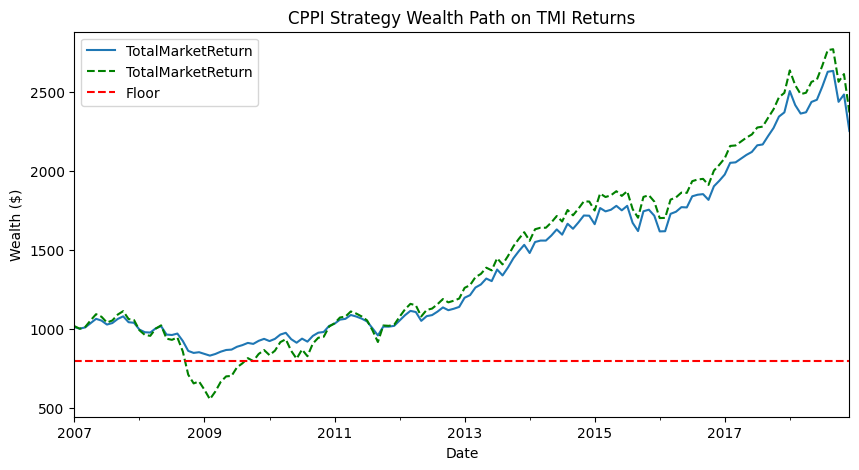

In [62]:
btr = erk.run_cppi(tmi_return["2007":])
ax = btr["Wealth"].plot(figsize=(10, 5), title="CPPI Strategy Wealth Path on TMI Returns", label="CPPI")
btr["Risky Wealth"].plot(ax=ax, style="g--", label="Risky Asset")
ax.axhline(y=0.8 * 1000, color="r", linestyle="--", label="Floor")
ax.legend()
ax.set_xlabel("Date")
ax.set_ylabel("Wealth ($)")

In [63]:
erk.summary_stats(btr["Risky Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
TotalMarketReturn,0.073411,0.150463,-0.734939,4.523488,0.071592,0.096315,0.280618,-0.499943


In [64]:
erk.summary_stats(btr["Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
TotalMarketReturn,0.069416,0.100381,-0.588292,3.740932,0.045678,0.062953,0.382052,-0.229683


Text(0, 0.5, 'Wealth ($)')

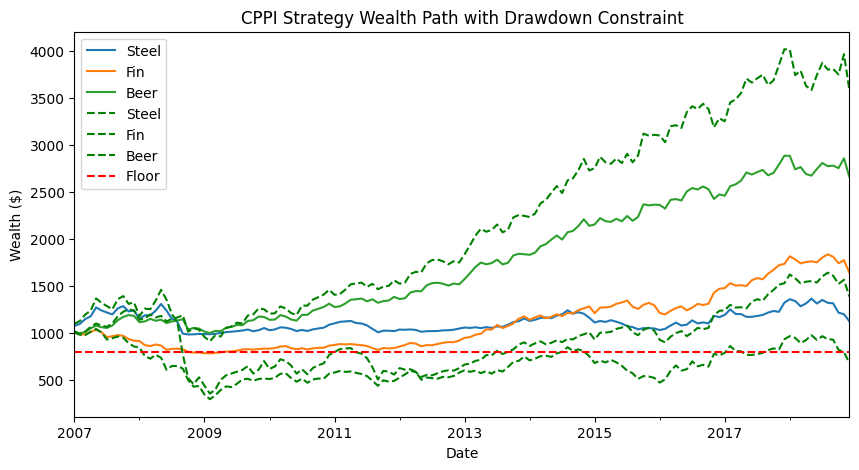

In [70]:
btr = erk.run_cppi(ind_return["2007":][["Steel","Fin","Beer"]], drawdown=0.25)
ax = btr["Wealth"].plot(figsize=(10, 5), title="CPPI Strategy Wealth Path with Drawdown Constraint", label="CPPI")
btr["Risky Wealth"].plot(ax=ax, style="g--", label="Risky Asset")
ax.axhline(y=0.8 * 1000, color="r", linestyle="--", label="Floor")
ax.legend()
ax.set_xlabel("Date")
ax.set_ylabel("Wealth ($)")

In [69]:
erk.summary_stats(btr["Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,0.003784,0.097073,-0.441089,5.220481,0.047371,0.066991,-0.262958,-0.248059
Fin,0.041975,0.085028,-0.355163,4.153860,0.038342,0.054111,0.136964,-0.243626
Beer,0.084375,0.086263,-0.744111,4.571533,0.037937,0.051189,0.613413,-0.161186


In [71]:
erk.summary_stats(btr["Risky Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.039660,0.306407,-0.459951,4.782828,0.152288,0.203837,-0.221642,-0.758017
Fin,0.027364,0.212204,-0.695200,4.621401,0.105744,0.149862,-0.012370,-0.718465
Beer,0.111554,0.127971,-0.670797,4.650878,0.056497,0.077388,0.620132,-0.271368
